# 1.  U-Net trained on public datasets
This notebook is for training a model on public data. The goal is to train a model that will be used to find cell instances in the data from the SweBCH91RT study.

In [1]:
import random
import json
import os
import time

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import tensorflow as tf

#gpu = tf.config.experimental.list_physical_devices("GPU")[0]
#tf.config.experimental.set_memory_growth(gpu, True)

import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from keras.models import Model, load_model
from keras.layers import Input, multiply
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras
import pandas as pd

import wandb
from wandb.keras import WandbCallback

from weighted_loss_unet import make_weighted_loss_unet, my_loss
from augmented_sequence import AugmentedSequence

import config
import importlib

importlib.reload(config)
c = config.Config()

## Data augmentation

In [2]:
import augmented_dataset
import dataset
import utils
importlib.reload(augmented_dataset)
from augmented_dataset import AugmentedDataset
from dataset import Monuseg, Bns, Quip
import random

seq = iaa.Sequential(
    [
        iaa.CropToFixedSize(width=round(c.WIDTH*4.0), height=round(c.HEIGHT*4.0)),
        #iaa.Affine(rotate=(0,360),
        #           scale={"x":(0.8, 1.2), "y":(0.8, 1.2)},
        #           shear=(-8, 8)),
        # iaa.Resize({"height" : c.HEIGHT,  "width" : c.WIDTH}),
        # iaa.Sometimes(0.2, iaa.GaussianBlur(sigma=(0.0, 1.0))),
        # iaa.AddToHue((-25, 25)),
        # iaa.Sometimes(0.2, iaa.EdgeDetect((0,0.5)))
        iaa.CropToFixedSize(width=c.WIDTH, height=c.HEIGHT, position="center"),
        iaa.Sometimes(0.1, iaa.SigmoidContrast(gain=(5, 6))),
        iaa.AddToHue((-25, 25))
    ]
)

val_sequential = iaa.Sequential(
    [
        iaa.CropToFixedSize(width=c.WIDTH, height=c.HEIGHT),
    ]
)

f = lambda x : AugmentedDataset(Quip(4000), seq, 2, scale = 0.75).prefetch(tf.data.experimental.AUTOTUNE)
ds_train = tf.data.Dataset.range(1).interleave(
        f,
        num_parallel_calls=2
    )

val, _ = Bns().make_split(0.5)
ds_val = AugmentedSequence(val, val_sequential, scale = 1.0)


## Sanity check

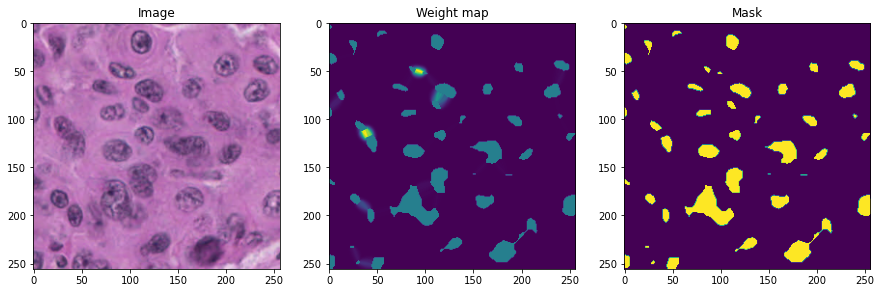

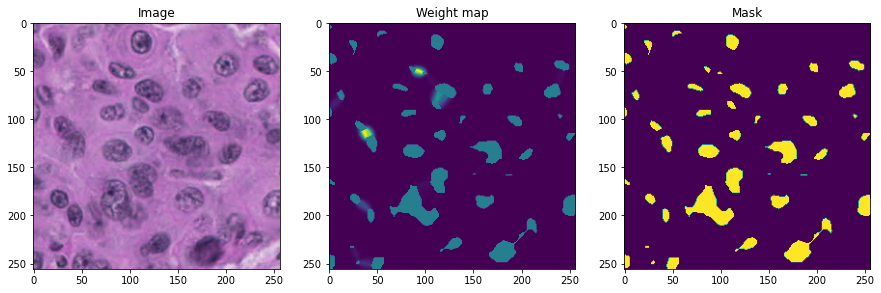

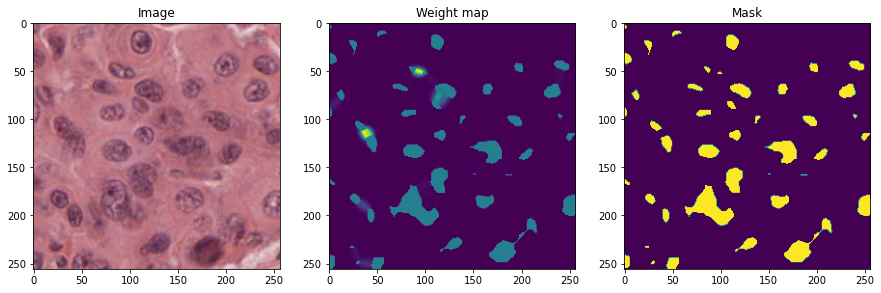

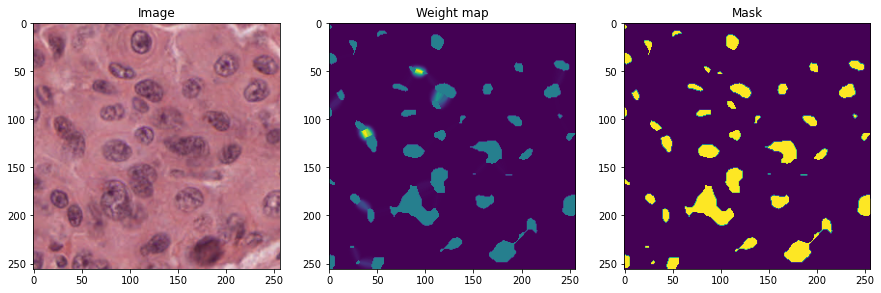

In [3]:
(img_b, wmap_b), mask_b = ds_train.as_numpy_iterator().__next__()
for idx in range(4):
    img = img_b[idx]
    wmap = wmap_b[idx, ..., 1]
    mask = mask_b[idx, ..., 1]
    border = mask_b[idx, ..., 2]

    plt.figure(figsize=(15, 8))
    plt.subplot(131)
    plt.imshow(img)
    plt.title("Image")
    plt.subplot(132)
    plt.imshow(wmap)
    plt.title("Weight map")
    plt.subplot(133)
    #plt.imshow(mask + border)
    plt.title("Mask")
    plt.imshow(mask)

## Train U-Net
The U-Net, along with the weight map loss function, was implemented by [jaidevd](https://jaidevd.github.io/posts/weighted-loss-functions-for-instance-segmentation/).

In [4]:
def iou(y_true, y_pred):
    y_true = y_true[0]
    intersection = K.sum(K.abs(y_true[..., 1] * y_pred[..., 1]), axis=-1)
    union = K.sum(K.abs(y_true[..., 1]) + K.abs(y_pred[..., 1]), axis=-1)
    jac = (intersection) / (union)
    return 1 - jac

In [5]:
notes = (
    """
        Downscaling to 0.75, with augmentation.
    """)
name = f"unet_quip_aug_075"

In [6]:
# tf.compat.v1.disable_eager_execution()
model_dir = "../models/unet"
os.makedirs(model_dir, exist_ok=True)
if f"{name}.h5" in os.listdir(model_dir):
    print("Loading existing model...", end="")
    model = keras.models.load_model(
        f"{model_dir}/{name}.h5", custom_objects={"my_loss": my_loss, "iou": iou}
    )
    print("Done!")
else:
    wandb.init(project="histosnet", name=name, notes=notes)
    model = make_weighted_loss_unet(is_training=True)
    model.compile(optimizer="adam", loss=my_loss)
    try:
        model.fit(ds_train, validation_data = ds_val, epochs=c.EPOCHS, callbacks=[WandbCallback()])
    except KeyboardInterrupt:
        time_str = time.strftime("%Y%m%d-%H%M%S")
        name += f"_aborted_{time_str}"
    model.save(os.path.join(wandb.run.dir, "model.h5"))
    # Our inference model won't take a weight map as an input.
    model_inference = make_weighted_loss_unet(is_training=False)
    model_inference.set_weights(model.get_weights())
    model_inference.save(f"{model_dir}/{name}.h5")
    model = model_inference

Loading existing model...WARNING:tensorflow:No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
Done!


## Post-processing

In [7]:
import skimage.morphology as morphology
from scipy.optimize import minimize
from itertools import islice


def make_sequence(patient_ids):
    """ Making a regular sequence without any augmentations. """
    crop_seq = iaa.Sequential([iaa.CropToFixedSize(width=IMG_WIDTH, height=IMG_HEIGHT)])
    return AugmentedSequence(patient_ids, BATCH_SIZE, crop_seq, IMG_WIDTH, IMG_HEIGHT)


def iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union


def mean_iou(y_true: list, y_pred: list):
    return np.mean([iou(yt, yp) for yt, yp in zip(y_true, y_pred)])


img_batches, y_true_batches = zip(
    *[
        (img_b, mask_b)
        for (img_b, _), mask_b in ds_val
    ]
)
y_pred_batches = [model.predict(img_b) for img_b in img_batches]

y_true = [y[..., 1] + y[..., 2] for batch in y_true_batches for y in batch]
y_pred = [y[..., 1] for batch in y_pred_batches for y in batch]


def loss(p):
    return -mean_iou(y_true, [post_processing(y, p) for y in y_pred])

In [16]:
# Optimize post-processing parameters
def post_processing(prediction, cutoff, size_limit = 10):
    prediction = prediction > cutoff
    #prediction = morphology.remove_small_holes(prediction, area_threshold=p[1])
    #prediction = morphology.remove_small_objects(prediction, min_size=p[1])
    prediction = morphology.dilation(prediction, morphology.diamond(2))
    prediction = morphology.remove_small_objects(prediction, size_limit)
    return prediction


p = 0.1
#p_optimal = minimize(loss, p, method="Nelder-Mead", options={"disp": True})["x"]

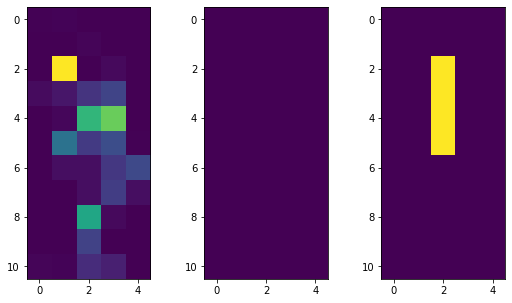

In [18]:
n = 1
p=0.2
plt.figure(figsize=(9, 5))
plt.subplot(131)
plt.imshow(y_pred[n])
plt.subplot(132)
plt.imshow(post_processing(y_pred[n], p))
plt.subplot(133)
plt.imshow(y_true[n])

## Predict of validation set

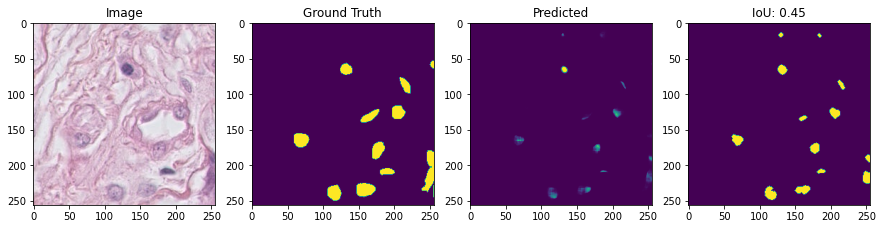

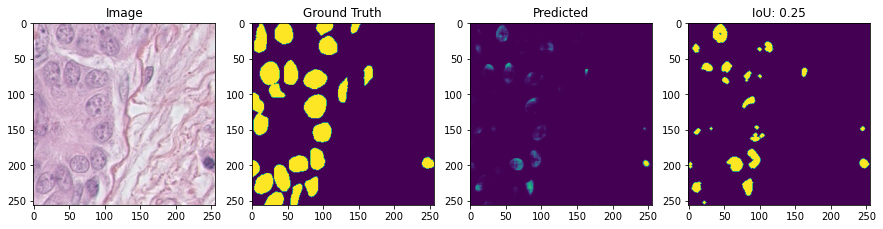

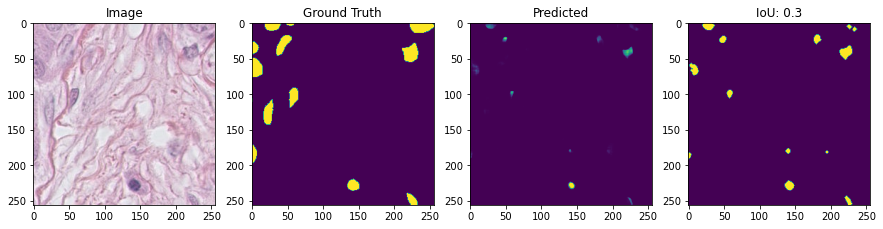

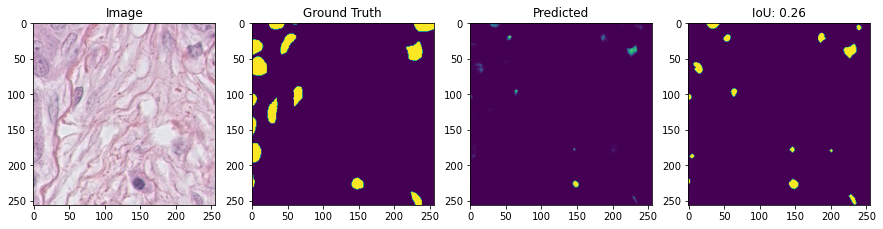

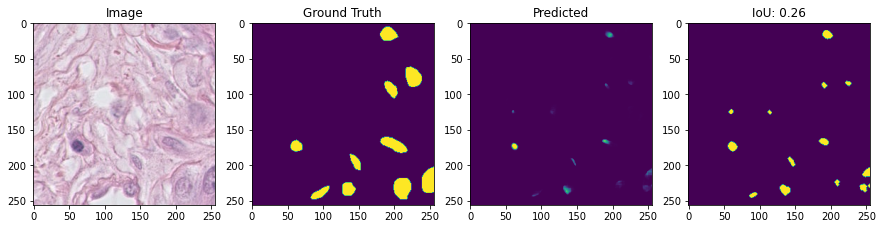

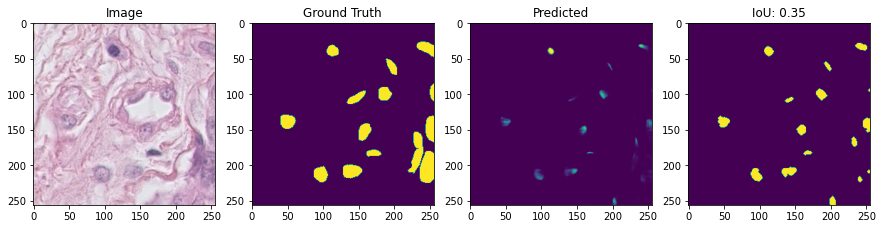

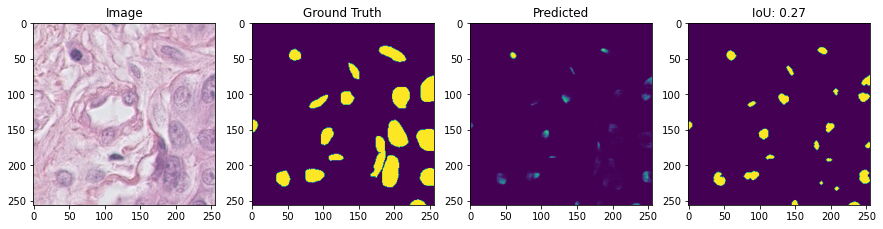

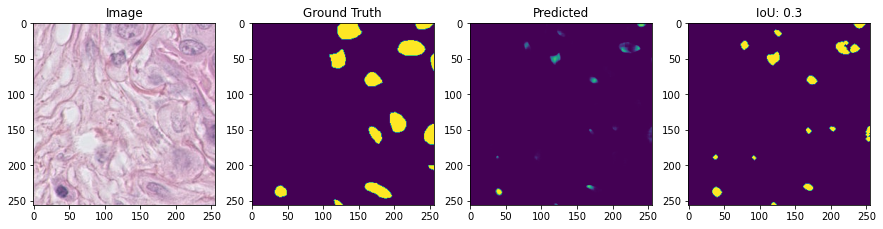

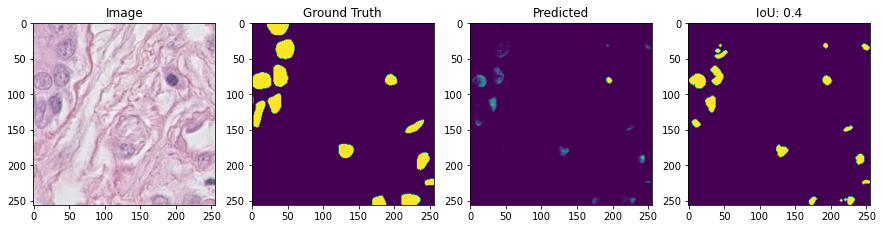

In [26]:
import random 

cutoff = 0.1
size_limit = 5
def display_result(model, aug_sequence, batch_limit=1):
    for ((img_b, _), mask_b) in random.choices(aug_sequence, k=batch_limit):
        prediction = model.predict(img_b)
        for img, mask, pred in zip(img_b, mask_b, prediction):
            y_true = mask[...,1] + mask[...,2]
            plt.figure(figsize=(15, 8))
            plt.subplot(141)
            plt.imshow(img)
            plt.title("Image")

            plt.subplot(142)
            plt.imshow(y_true)
            plt.title("Ground Truth")

            plt.subplot(143)
            plt.imshow(pred[:, :, 1])
            plt.title("Predicted")

            plt.subplot(144)
            pred = post_processing(pred[..., 1], cutoff, size_limit)
            intersection = np.logical_and(y_true, pred).sum()
            union = np.logical_or(y_true, pred).sum()
            iou = round(intersection / union, 2)
            plt.imshow(pred)
            plt.title(f"IoU: {iou}")

display_result(model, ds_val)

In [11]:
from retrying import retry
from functools import wraps
from skimage import measure
from scipy.ndimage import find_objects
from config import Config
from joblib import Memory

memory = Memory('./cache')
c = Config()


def mean_iou(true, pred, cutoff):
    iou = []
    for true, pred in zip(true, pred):
        pred = post_processing(pred, cutoff)
        intersection = np.logical_and(true, pred).sum()
        union = np.logical_or(true, pred).sum()
        iou.append(intersection / union)
    return np.mean(iou)

def predict_sample(model, data, n=50):
    # Not fully annotated
    if type(data) == list:
        for chunk in chunks(random.choices(data, k=n), c.BATCH_SIZE):
            img_b, mask_b, box_b = zip(*chunk)
            prediction = model.predict(np.array(img_b))
            K.clear_session()
            for img, mask, pred, box in zip(img_b, mask_b, prediction, box_b):
                true = mask[box]
                pred = pred[box]
                yield true, pred[...,1]
                
    # Fully annotated
    else:
        for ((img_b, _), mask_b) in random.choices(data, k=n):
            prediction = model.predict(img_b)
            K.clear_session()
            for img, mask, pred in zip(img_b, mask_b, prediction):
                true = mask[...,1]
                pred = pred[...,1]
                assert not type(pred) == tuple
                yield true, pred

def expand_slice(box):
    width, height = (box[0].stop - box[0].start, box[1].stop - box[1].start)
    return (
        slice(box[0].start - c.WIDTH//2, box[0].stop + c.WIDTH//2 - width, None),
        slice(box[1].start - c.HEIGHT//2, box[1].stop + c.HEIGHT//2 - height, None),
    )

def get_objects(mask):
    all_labels = measure.label(mask, background=0)
    return find_objects(all_labels)

def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield np.array(lst[i : i + n])


def make_tile(image, mask, box):
    expanded_box = expand_slice(box)
    tile_img = image[expanded_box]
    tile_mask = np.zeros((3000, 3000))
    tile_mask[box] =  mask[1:,1:]
    tile_mask = tile_mask[expanded_box]
    location = get_objects(tile_mask)[0]
    tile_mask = (utils.get_boundary_mask(tile_mask) == 1).astype(np.uint8)
    return tile_img, tile_mask, location


def get_tnbc_tiles(df):
    tiles = []
    tnbc = TNBC1()
    for imid, df_img in df.groupby("image_id"):
        img = tnbc.load_image(imid)
        tiles.extend([make_tile(img, mask, box) for mask, box in zip(df_img["mask"], df_img["obj"])])
    return tiles

import dataset
importlib.reload(dataset)
from dataset import TNBC1
tnbc = TNBC1()

df = tnbc.get_dataframe()
df = df[df['class'] != 'rbc']
df = df[df['class'] != 'necrosis']
df = df[df['class'] != 'stroma']
df['size'] = df['mask'].apply(np.sum)
df_tnbc = df[df['size'] != 0]

In [12]:
# ROC
from sklearn.metrics import roc_curve, auc # roc curve tools

def roc(true, pred):
    true, pred = zip(*[(t.ravel(), p.ravel()) for t,p in zip(true, pred)])
    true, pred = np.hstack(true), np.hstack(pred)
    fpr, tpr, thresholds = roc_curve(true,pred)
    
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    optimal_threshold
    return fpr, tpr, optimal_threshold


In [13]:
from dataset import Monuseg, Bns, TNBC1
from itertools import product

from tqdm import tqdm

monuseg = lambda : AugmentedSequence(Monuseg().make_split(0.5)[0], val_sequential)
bns = lambda : AugmentedSequence(Bns().make_split(0.5)[0], val_sequential)
tnbc = lambda : get_tnbc_tiles(df_tnbc)

upscale_seq= iaa.Sequential(
    [
        iaa.CropToFixedSize(
            width=int(c.WIDTH / 2), height=int(c.HEIGHT / 2), position="center"
        ),
        iaa.Resize({"height": c.HEIGHT, "width": c.WIDTH}),
    ]
)

scales = [1.0]
datasets = {
    "monuseg" : monuseg,
    "bns" : bns,
    "tnbc" : tnbc,
    
}
model_names = ["unet_quip_10000",
               "unet_quip_ds",
               "unet_quip_ds_aug"]
augs = [val_sequential]

d = []
n = 10
for dataset_name, dataset_func in tqdm(list(datasets.items())):
    dataset = dataset_func()
    for model_name in model_names:
        model = keras.models.load_model(
            f"{model_dir}/{model_name}.h5", custom_objects={"my_loss": my_loss, "iou": iou},
            compile = False
        )
        y_true, y_pred = zip(*[pred for pred in predict_sample(model, dataset, n)])
        
        fpr, tpr, optimal_threshold = roc(y_true, y_pred)
        
        for cutoff in np.arange(0.008, 0.12, 0.02):
            iou = mean_iou(y_true, y_pred, cutoff)
    
            d.append({
                "dataset" : dataset_name,
                "iou" : iou, 
                "model" : model_name,
                "cutoff" : cutoff,
                "optimal_cutoff" : optimal_threshold,
                "fpr" : fpr,
                "tpr" : tpr
            })
    
df = pd.DataFrame(d)
df.to_pickle("unet_evalutation.pickle")

 67%|██████▋   | 2/3 [00:34<00:19, 19.37s/it]<ipython-input-11-2048ca7e5719>:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  yield np.array(lst[i : i + n])
100%|██████████| 3/3 [01:30<00:00, 30.25s/it]


In [14]:
np.arange(0.1,1.1, 0.02)

array([0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 , 0.22, 0.24, 0.26, 0.28, 0.3 ,
       0.32, 0.34, 0.36, 0.38, 0.4 , 0.42, 0.44, 0.46, 0.48, 0.5 , 0.52,
       0.54, 0.56, 0.58, 0.6 , 0.62, 0.64, 0.66, 0.68, 0.7 , 0.72, 0.74,
       0.76, 0.78, 0.8 , 0.82, 0.84, 0.86, 0.88, 0.9 , 0.92, 0.94, 0.96,
       0.98, 1.  , 1.02, 1.04, 1.06, 1.08])

## Predict on TNBC set

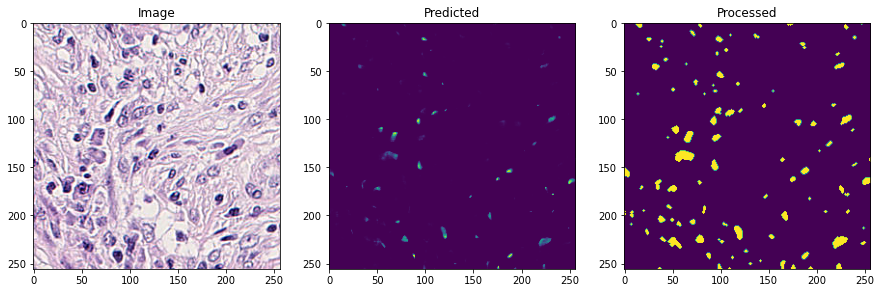

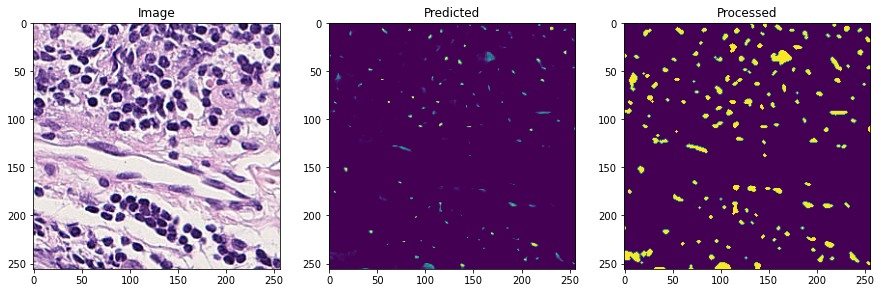

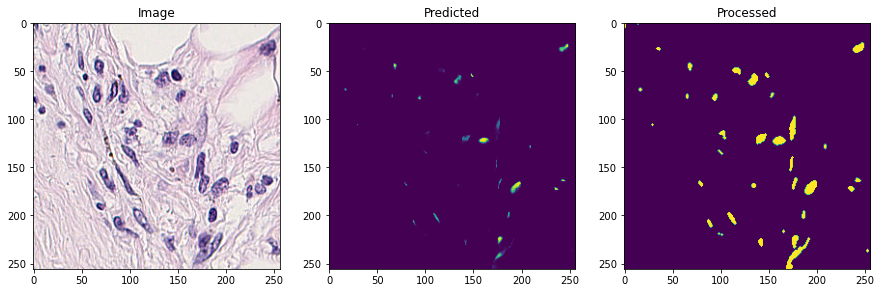

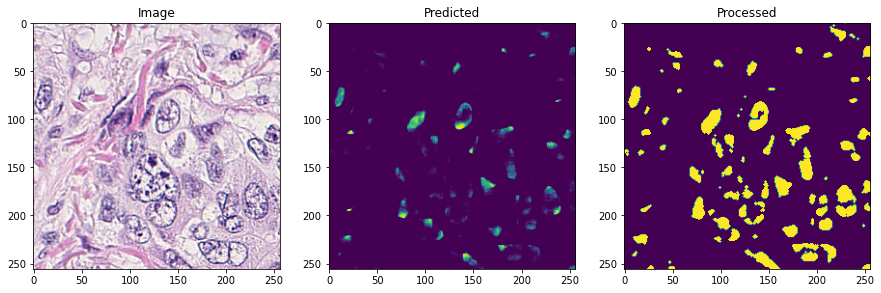

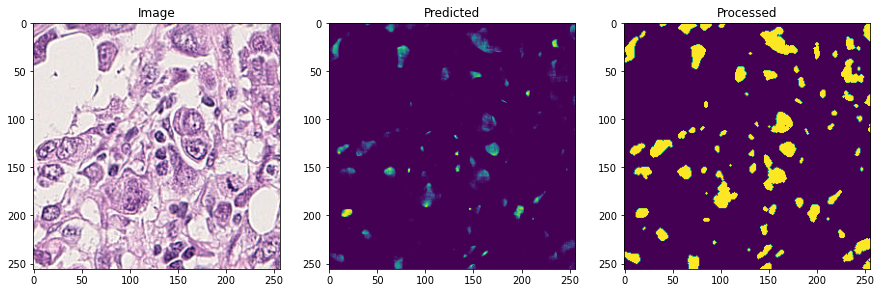

In [15]:
import dataset
from dataset import TNBC1, TNBC2
from tqdm import tqdm

tnbc = TNBC2()

p = 0.02

tnbc_sequential = iaa.Sequential(
    [
        iaa.CropToFixedSize(
            width=int(c.WIDTH / 1), height=int(c.HEIGHT / 1), position="center"
        ),
        #iaa.Resize({"height": c.HEIGHT, "width": c.WIDTH}),
    ]
)

images = [tnbc.load_image(pid) for pid in tnbc.ids[40:45]]
for img_b in chunks(tnbc_sequential(images=images), c.BATCH_SIZE):
    prediction = model.predict(img_b)
    for img, pred in zip(img_b, prediction):
        plt.figure(figsize=(15, 8))
        plt.subplot(131)
        plt.imshow(img)
        plt.title("Image")

        plt.subplot(132)
        plt.imshow(pred[:, :, 1])
        plt.title("Predicted")

        plt.subplot(133)
        pred = post_processing(pred[..., 1], p)
        plt.imshow(pred)
        plt.title("Processed")